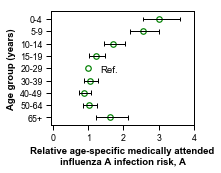

In [1]:
import glob
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import numpy as np
%matplotlib inline

df = pd.read_csv('../final_results_for_ms/0-100/DAHVage_subtype.profile_liks.csv').dropna()
pal = sns.xkcd_palette(['dark sky blue', 'deep red']).as_hex()
h1color=pal[0]
h3color=pal[1]

rcParams['mathtext.default'] = 'regular'
rcParams['font.sans-serif'] = 'arial'
rcParams['svg.fonttype'] = 'none'
sns.set_context('paper')


df['CI_upper'] = df.prof_max
df['CI_lower'] = df.prof_min
plot_params = {'markersize': 5.5,
               'markeredgewidth': 1.2,
               'color': 'white'}


ylabs = []
yticks = []
index = 0
for i, row in df.iterrows():

    if row.param[0] == 'A':

        plt.hlines(y=-index, xmin=row.CI_lower, xmax=row.CI_upper, linewidth=1)
        plt.vlines(x=row.CI_lower, ymin=-index-0.2, ymax=-index+0.2, linewidth=1)
        plt.vlines(x=row.CI_upper, ymin=-index-0.2, ymax=-index+0.2, linewidth=1)
        plt.plot([row.mle], [-index], 'o', **plot_params, markeredgecolor='green', zorder=1)
        if row.param != 'A65.100':
            ylabs.append(row.param[1:].replace('.','-'))
        else:
            ylabs.append('65+')
        yticks.append(-index)
        index += 1
        
        if row.param == 'A15.19':
            plt.plot([1], [-index], 'o', **plot_params, markeredgecolor='green')
            ylabs.append('20-29')
            yticks.append(-index)
            plt.annotate('Ref.', (1.35, -index - 0.1), va='center')
            index += 1
        
plt.xlabel('Relative age-specific medically attended\ninfluenza A infection risk, A', weight='bold')
plt.xlim(-0.05, 4)
plt.ylabel('Age group (years)', weight='bold')
plt.yticks(yticks, ylabs)


plt.gcf().set_size_inches(3, 2.5)
plt.tight_layout()

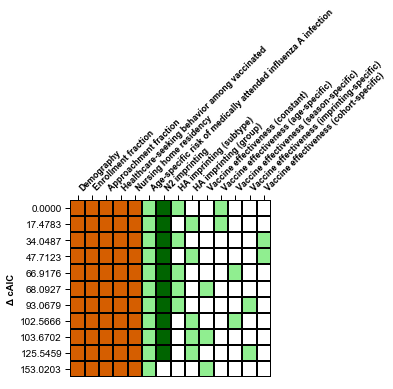

In [2]:
df = pd.read_csv('../final_results_for_ms/0-100/result_summary.csv', index_col='Unnamed: 0')

pal = sns.color_palette('colorblind').as_hex()
flatui = ['white', pal[3], 'darkgreen', 'lightgreen']
my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())


rcParams['font.sans-serif'] = 'arial'
sns.set_context('paper')
full_model='DAHNV'

final_df = pd.DataFrame(columns=['D', 'E', 'Ap', 'vac_cov', 'Nu', 'A', 'N2', 'H_sub','H_group', 'V_constant', 'V_age', 'V_season', 'V_imprinting', 'V_cohort', 'cAIC'])
row = 0

df = df.iloc[1:, ]

exclude = ['DAHVage_subtype', 'DAHVcohort_subtype', 'DAVseason', 'DAVimprinting', 'DAVage', 'DAVcohort']

for model, r in df.iterrows():
    if model not in exclude:
        if 'Vage' in model:
            V = 'V_age'
            final_df.loc[row, V] = 1
        elif 'Vseason' in model:
            V = 'V_season'
            final_df.loc[row, V] = 1
        elif 'Vimprinting' in model:
            V = 'V_imprinting'
            final_df.loc[row, V] = 1
        elif 'Vcohort' in model:
            V = 'V_cohort'
            final_df.loc[row, V] = 1
        elif 'Vmean' in model:
            V = 'V_constant'
            final_df.loc[row, V] = 1

        if 'H' in model:
            if 'subtype' in model:
                final_df.loc[row, 'H_sub'] = 1
            elif 'group' in model:
                final_df.loc[row, 'H_group'] = 1

        if 'N' in model:

            if r['N2m'] != 0:
                final_df.loc[row, 'N2'] = 0.5
            else:
                final_df.loc[row, 'N2'] = 0.5
        final_df.loc[row, 'A'] = 1
        final_df.loc[row, 'D'] = 0.25
        final_df.loc[row, 'E'] = 0.25
        final_df.loc[row, 'Ap'] = 0.25
        final_df.loc[row, 'vac_cov'] = 0.25
        final_df.loc[row, 'Nu'] = 0.25
        #final_df.loc[row, '']
        final_df.loc[row, 'cAIC'] = r.cAIC
        row += 1

final_df = final_df.sort_values('cAIC')
final_df = final_df.fillna(0)
final_df.index = ["%.4f" % (c - min(final_df['cAIC'])) for c in final_df['cAIC']]
final_df = final_df.loc[:, final_df.columns != 'cAIC']
final_df.columns = ['Demography',
                    'Enrollment fraction',
                    'Approachment fraction',
                    'Healthcare-seeking behavior among vaccinated',
                    'Nursing home residency',
                    'Age-specific risk of medically attended influenza A infection',
                    'N2 imprinting',
                    'HA imprinting (subtype)',
                    'HA imprinting (group)',
                    'Vaccine effectiveness (constant)',
                    'Vaccine effectiveness (age-specific)',
                    'Vaccine effectiveness (season-specific)',
                    'Vaccine effectiveness (imprinting-specific)',
                    'Vaccine effectiveness (cohort-specific)']
sns.heatmap(final_df, cmap=my_cmap, linewidths=1, linecolor='black', cbar=False, yticklabels=1)
ax = plt.gca()
ax.xaxis.tick_top()
plt.yticks(rotation=0, fontsize=10)
plt.xticks(rotation=45, ha='left', weight='bold')
plt.ylabel('Δ cAIC', weight='bold')
f = plt.gcf()
f.set_size_inches(5.5, 5.5)
plt.tight_layout()